In [58]:
import pandas as pd
import optuna
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [59]:
def xgb_objective(trial):
    # Define hyperparameters space using trial object
    param = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'booster': 'gbtree',
        'n_jobs': -1,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 5),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0.0, 1.0),
        'alpha': trial.suggest_float('alpha', 1e-5, 1.0, log=True),
        'lambda': trial.suggest_float('lambda', 1e-5, 1.0, log=True)
    }
    
    # Initialize and train the model
    model = xgb.XGBRegressor(**param)
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=50, verbose=False)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Compute RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    return rmse

In [60]:
# Load dataset
df = pd.read_csv('test-data/2015_to_2022_dataset.csv')

In [61]:
# Replace missing values with NaN
df.replace("", np.nan, inplace=True)

In [62]:
df.isnull().sum()

Code                         0
Locale                       0
Date                         0
Temperature                  7
Precipitation            63134
Wind_Speed                  55
Wind_Direction              68
Humidity                    35
Vapor_Pressure               7
Dew_Point_Temperature       10
Spot_Atm_Pressure           21
Sea_Level_Pressure          17
Daylight_Time            32027
Insolation               31852
Snowfall_Amount          68051
Clouds_Amount             7111
Ground_Temperature          67
SO2                       1486
CO                        2672
NO2                       2074
PM10                      1436
PM2_5                     1330
O3                        1397
dtype: int64

In [63]:
df['Date'] = pd.to_datetime(df['Date'])
df['Date'] = df['Date'].dt.strftime('%y%m%d%H')
df['Date'] = df['Date'].astype(int)

df['Year'] = df['Date'].apply(lambda x: 2000 + int(str(x)[:2]))  # Adding 2000 to get the full year, e.g., 2015
df['Month'] = df['Date'].apply(lambda x: int(str(x)[2:4]))
df['Day'] = df['Date'].apply(lambda x: int(str(x)[4:6]))
df['Hour'] = df['Date'].apply(lambda x: int(str(x)[6:]))

In [64]:
# Define the columns to be imputed with the median
median_columns = [
    'Temperature', 'Wind_Speed', 'Wind_Direction', 'Humidity',
    'Vapor_Pressure', 'Dew_Point_Temperature', 'Spot_Atm_Pressure',
    'Sea_Level_Pressure', 'SO2', 'CO', 'NO2', 'PM10', 'PM2_5', 'O3',
    'Ground_Temperature'
]

# Define the columns to be imputed with zero
zeroing_columns = [
    'Precipitation', 'Daylight_Time', 'Insolation',
    'Snowfall_Amount', 'Clouds_Amount'
]

# Create imputer for median
imputer_median = SimpleImputer(strategy='median')

# Apply the imputer to the columns that require the median
df[median_columns] = imputer_median.fit_transform(df[median_columns])

# Fill the NaN values with zero for the columns that require zeroing
df[zeroing_columns] = df[zeroing_columns].fillna(0)

# Check if there are any remaining NaN values
print(df.isnull().sum())

Code                     0
Locale                   0
Date                     0
Temperature              0
Precipitation            0
Wind_Speed               0
Wind_Direction           0
Humidity                 0
Vapor_Pressure           0
Dew_Point_Temperature    0
Spot_Atm_Pressure        0
Sea_Level_Pressure       0
Daylight_Time            0
Insolation               0
Snowfall_Amount          0
Clouds_Amount            0
Ground_Temperature       0
SO2                      0
CO                       0
NO2                      0
PM10                     0
PM2_5                    0
O3                       0
Year                     0
Month                    0
Day                      0
Hour                     0
dtype: int64


In [65]:
df = df.drop(columns = ['Code','Date', 'Locale'])

In [67]:
df = df.drop(columns = ['NO2','SO2', 'CO','PM10','PM2_5'])

<AxesSubplot:>

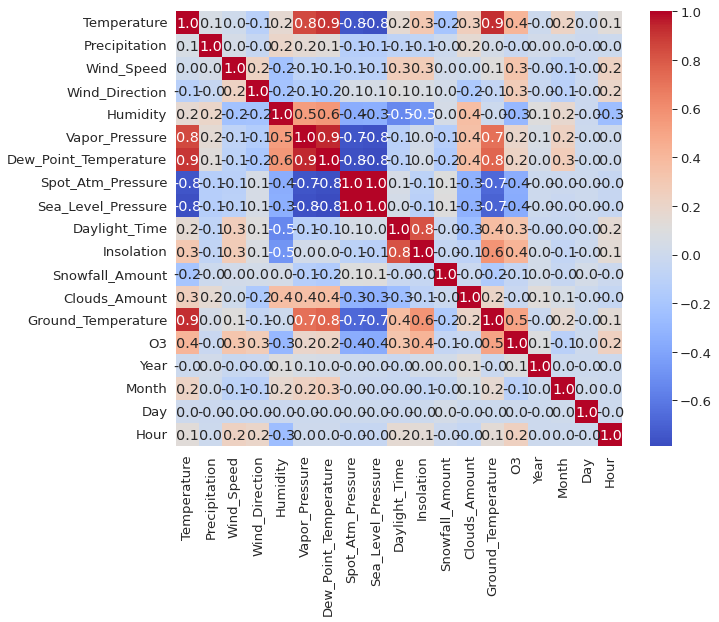

In [68]:
corr = df.corr()

sns.set_style('whitegrid')

sns.set_context('paper', font_scale=1.5)
plt.figure(figsize=(10, 8)) 
sns.heatmap(corr, cmap='coolwarm', annot=True, fmt='.1f')

In [69]:
# Specify the target variable
y = df['O3']

In [70]:
# Specify the feature variables
X = df.drop(['O3'], axis=1)

In [71]:
# Feature Scaling
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [72]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [47]:
# Define the hyperparameters grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [6, 10, 15, 20],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.5, 0.7, 1],
    'colsample_bytree': [0.5, 0.7, 1]
}

In [48]:
# Initialize XGBRegressor
xgb_reg = xgb.XGBRegressor(random_state=42, objective='reg:squarederror')

# Initialize GridSearchCV
grid_search = GridSearchCV(xgb_reg, param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best parameters: ", grid_search.best_params_)

# Initialize XGBRegressor with the best parameters
model = grid_search.best_estimator_

# Fit the model
model.fit(X_train, y_train)

In [73]:
# Create a study object and specify the direction is 'minimize'.
study = optuna.create_study(direction='minimize')

# Optimize the study, the objective function is passed in as the first argument.
study.optimize(xgb_objective, n_trials=100)  # You can adjust the number of trials

# Results
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    
best_params = study.best_params
model = xgb.XGBRegressor(**best_params)
model.fit(X_train, y_train)

[I 2023-08-18 16:04:41,243] A new study created in memory with name: no-name-a76f186e-b132-4235-8c2c-ebc3d6888040
[I 2023-08-18 16:04:44,861] Trial 0 finished with value: 0.012420303892525986 and parameters: {'learning_rate': 0.07506961898570826, 'n_estimators': 973, 'max_depth': 4, 'min_child_weight': 3, 'subsample': 0.9006344599233869, 'colsample_bytree': 0.796179251214042, 'gamma': 0.05048414287123215, 'alpha': 0.024554276865512637, 'lambda': 0.0016985905919793863}. Best is trial 0 with value: 0.012420303892525986.
[I 2023-08-18 16:04:46,348] Trial 1 finished with value: 0.015559391387988885 and parameters: {'learning_rate': 0.2714570519576878, 'n_estimators': 333, 'max_depth': 4, 'min_child_weight': 2, 'subsample': 0.9314640196866649, 'colsample_bytree': 0.7391905719552454, 'gamma': 0.8241740875168825, 'alpha': 5.20748639430379e-05, 'lambda': 0.016305133369730183}. Best is trial 0 with value: 0.012420303892525986.
[I 2023-08-18 16:04:48,515] Trial 2 finished with value: 0.014846403

Best trial:
  Value: 0.009417402527036808
  Params: 
    learning_rate: 0.14219212708404297
    n_estimators: 749
    max_depth: 5
    min_child_weight: 2
    subsample: 0.8816409476914945
    colsample_bytree: 0.7245398190498437
    gamma: 0.0001518169430769433
    alpha: 0.060244079841154465
    lambda: 3.888296604228566e-05


XGBRegressor(alpha=0.060244079841154465, base_score=0.5, booster='gbtree',
             colsample_bylevel=1, colsample_bynode=1,
             colsample_bytree=0.7245398190498437, enable_categorical=False,
             gamma=0.0001518169430769433, gpu_id=-1, importance_type=None,
             interaction_constraints='', lambda=3.888296604228566e-05,
             learning_rate=0.14219212708404297, max_delta_step=0, max_depth=5,
             min_child_weight=2, missing=nan, monotone_constraints='()',
             n_estimators=749, n_jobs=64, num_parallel_tree=1, predictor='auto',
             random_state=0, reg_alpha=0.0602440797, reg_lambda=3.88829649e-05,
             scale_pos_weight=1, subsample=0.8816409476914945,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [74]:
# Make predictions
predictions = model.predict(X_test)

In [75]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print("RMSE: %f" % (rmse))

RMSE: 0.009417


In [76]:
# Calculate MAE
mae = mean_absolute_error(y_test, predictions)
print("MAE: %f" % (mae))

MAE: 0.006992


In [77]:
# Calculate R2 Score
r2 = r2_score(y_test, predictions)
print("R2 Score: %f" % (r2))

R2 Score: 0.759262


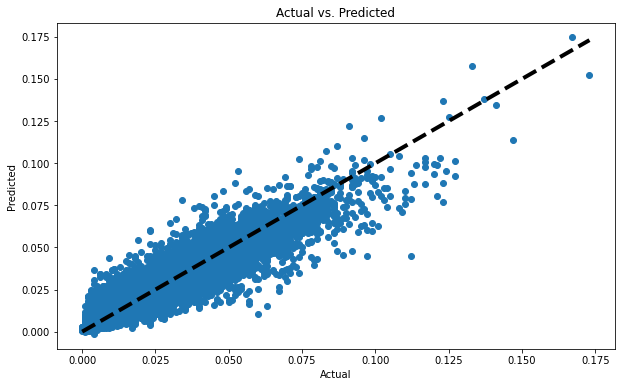

In [59]:
# Plot Actual vs. Predicted
plt.figure(figsize=(10,6))
plt.scatter(y_test, predictions)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted')
plt.show()

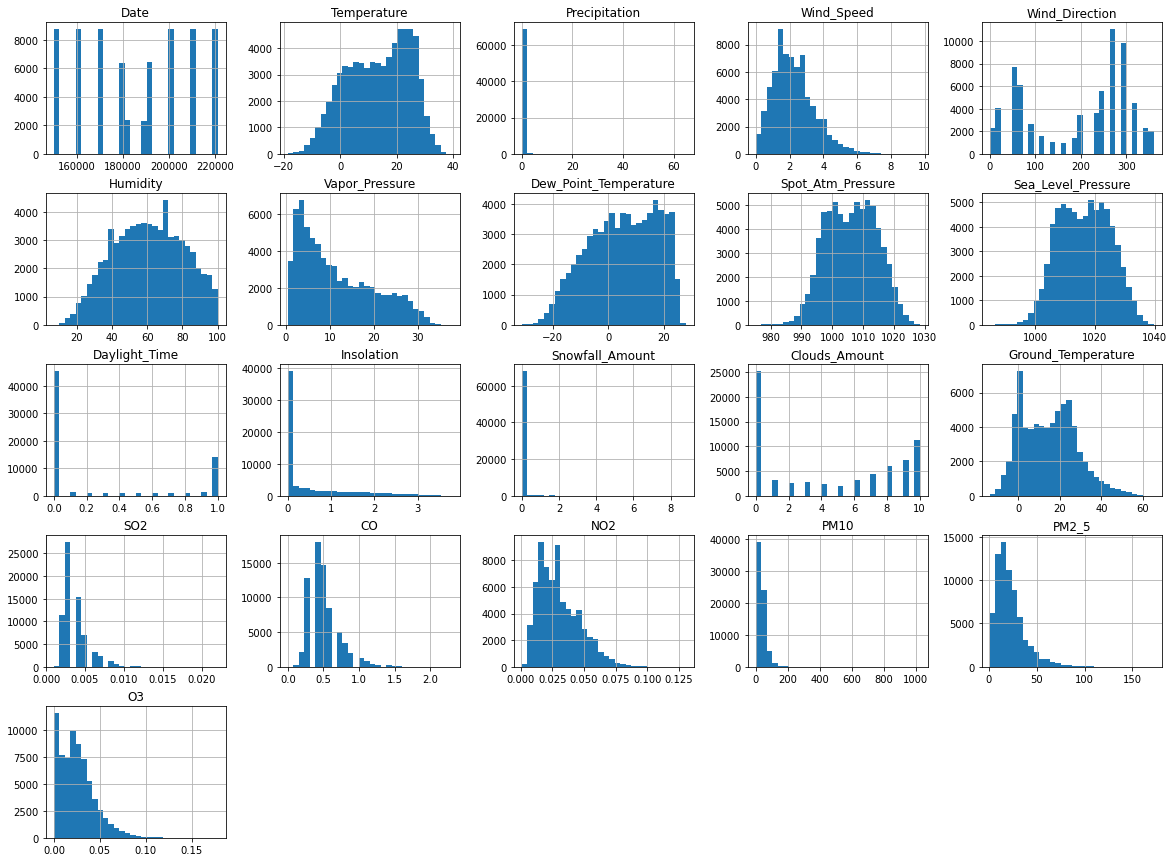

In [60]:
# Histograms for each variable in your dataset
df.hist(bins=30, figsize=(20,15))
plt.show()

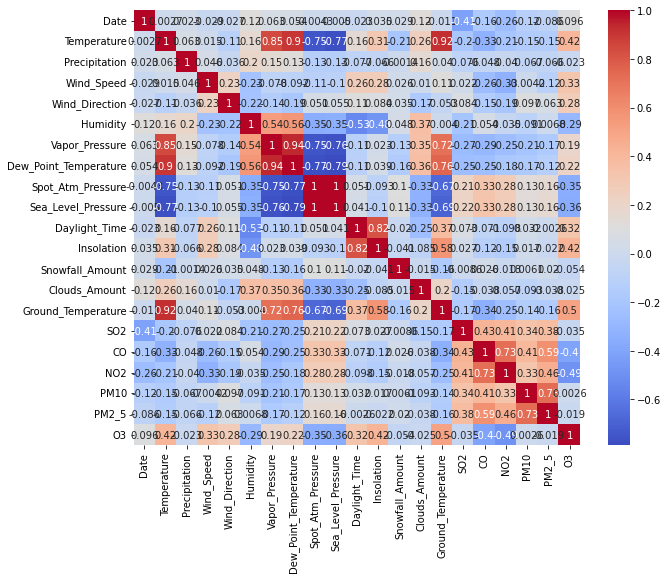

In [62]:
# Heatmap of Correlations
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.show()

ValueError: num must be 1 <= num <= 15, not 16

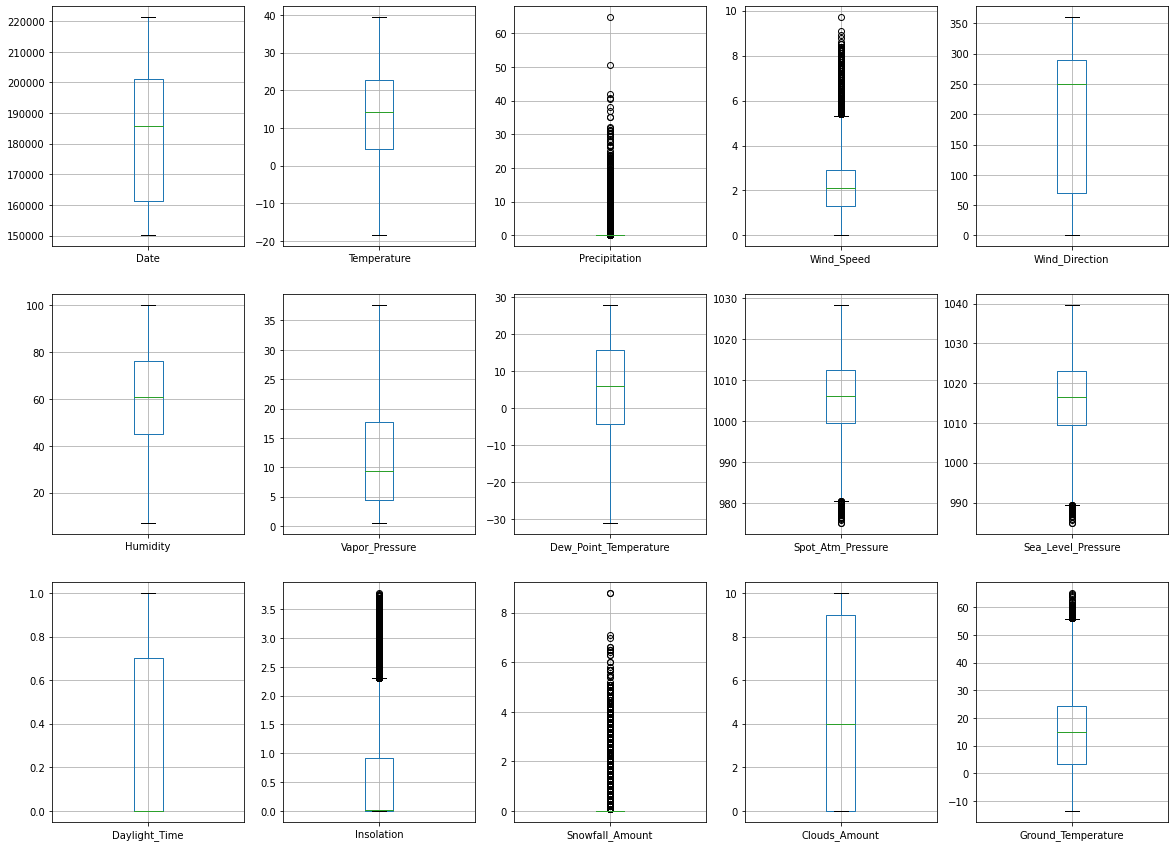

In [61]:
# Box plots for each variable
plt.figure(figsize=(20, 15))
for i, column in enumerate(df.columns, 1):
    plt.subplot(3, 5, i)
    df.boxplot(column)
plt.show()